In [77]:
# Solo implementation of a spatial transformer network including a process by which the 
# an image can be inserted and readjusted before transformation
# Although this is a functioning code example of a spatial transformer, it is currently 
# unable to generate educated transformations on the images, because it is not yet 
# integrated within a CNN. For the STN to properly learn how to perform the best transformation
# to diminish spatial invariance, it must learn from the loss function value which comes from the 
# implementation of the CNN. Without gradient descenet and backpropogation, the STN has no 
# delimiter to make its decisions on.
# Regardless, we will explore the structure and foundational aspects of the STN to better understand
# how these transformations are executed.
import tensorflow as tf
print(tf.__version__)
import numpy as np
from PIL import Image
from tensorflow.keras import layers, models

2.15.0


In [78]:
# Defining the input shape as a set size
target_image_path = 'birdtraining.jpeg'
input_shape = [224,224,3]
# Processing target image
def load_and_preprocess_image(image_path, input_shape):
    target_image = tf.io.read_file(image_path)
    target_image = tf.image.decode_image(target_image, channels=3)
    target_image = tf.image.resize(target_image, input_shape[:2])
    target_image = target_image / 255.0  # Normalize if your network expects inputs in this range
    target_image = tf.expand_dims(target_image, axis=0)  # Add batch dimension
    return target_image

# Use the function to load and preprocess the target image
target_image = load_and_preprocess_image(target_image_path, input_shape)

In [79]:
# Ulterior function that is not a fundamental to all STNs, responsible for 
# resizing the image
# Aspect ratio of an image is the height to wdith ratio
# Maintaining the aspect ratio helps avoid distortion of the image
def resize_image_keep_aspect_ratio(image, target_height, target_width):
    original_height = tf.shape(image)[0]
    original_width = tf.shape(image)[1]
    # establish the aspect ratio
    ratio = tf.cast(original_width / original_height, tf.float32)
    # set the height to the target height
    new_height = target_height
    # set the width to the target height multiplied by the aspect ratio
    new_width = tf.cast(target_height * ratio, tf.int32)

    # crop to ensure final image has same constraints, cropping keeps the
    # center of the image thus preserving the main content
    image = tf.image.resize(image, (new_height, new_width))
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image

In [80]:
# Function that applies the spatial transformation to the image based on the 
# transformation parameters defined in theta.
# input_fmap is the feature map to which the spatial transformation will be applied
# theta is the affine transformation matrix learned in the localization net
    # affine transformation matrix is a geometric transformation that preserves lines and 
    # parallelism (preserving collinearity)
# out_dims is the dimensions of the feature map and is set to the original dimensions if 
    # no value is provided
def spatial_transformer_network(input_fmap, theta, out_dims=None, **kwargs):
    # access the batch size (B), the height (H), and the width (W)
    B = tf.shape(input_fmap)[0]
    H = tf.shape(input_fmap)[1]
    W = tf.shape(input_fmap)[2]

    # reshaping theta to (B, 2, 3) so it matches expected format
    theta = tf.reshape(theta, [B, 2, 3])

    # generate a grid based on the dimensions
    if out_dims:
        out_H = out_dims[0]
        out_W = out_dims[1]
        batch_grids = affine_grid_generator(out_H, out_W, theta)
    else:
        batch_grids = affine_grid_generator(H, W, theta)

    x_s = batch_grids[:,0,:,:]
    y_s = batch_grids[:,1,:,:]
    
    # bilinear sampler samples the input at the given x and y coordinates
    # to create the output feature map
    out_fmap = bilinear_sampler(input_fmap, x_s, y_s)

    return out_fmap

In [81]:
# Learn the parameters of the spatial transformation that should be applied to
    # feature map
# Final output will be the parameters needed to transform the input feature map 
    # in a way that limits loss function value
def build_localization_network(input_shape):
    # linear stack of layers, where each layer has exactly one tensor input and output
    model = models.Sequential()

    # Two convolutional layers are defined, both proceeded by max pooling
    # Max pooling operation reports the maximum output within a rectangular neighborhood
    # Max pooling with pool size of 2x2 reduces the spatial dimensions of the convolutional
        # layers which helps to reduce computation and control overfitting
    model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Fully connected layers
    # Reshape the 2D feature map into a 1D Tensor for insertion into the dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))

    # Output layer with 6 units, initialized to the identity transformation
        # the 6 units correspond to the paramaters of the affine tranformation
        # matrix which is 2x3
    model.add(layers.Dense(6, activation='linear', 
                           kernel_initializer='zeros', 
                           bias_initializer=tf.constant_initializer([1, 0, 0, 0, 1, 0])))

    return model

In [82]:
# Helper function that extracts pixel values from an input feature map tensor 
    # based on specific x and y coordinates
def get_pixel_value(img, x, y):
    shape = tf.shape(x)
    batch_size = shape[0]
    height = shape[1]
    width = shape[2]

    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size,1,1))
    b = tf.tile(batch_idx, (1, height, width))

    indices = tf.stack([b,y,x], 3)

    return tf.gather_nd(img, indices)

In [83]:
# Grid generator that creates a grid of coordinates that are used to sample 
    # from an input feature map according to theta
# Effectively applies the learned spatial transformation to the input data
# Desired height, width and theta are the paramaters
def affine_grid_generator(height, width, theta):
    num_batch = tf.shape(theta)[0]

    x = tf.linspace(-1.0,1.0, width)
    y = tf.linspace(-1.0,1.0, height)
    # create a grid of (x,y) coordinates that represents the output feature map
    x_t, y_t = tf.meshgrid(x,y)

    # create 1D array of all coords in output feature map and add a third row
        # of ones so the affine transformation matrix (theta) can be properly 
        # multiplied to the grid
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    # create a third row of ones for the homogenuous coordinate system
    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])

    # expand the dimensions of the grid and replicate it for the whole batch
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))

    # certifty that both theta and the sampling grid are float 32 tensors
    theta = tf.cast(theta, 'float32')
    sampling_grid = tf.cast(sampling_grid, 'float32')

    # apply the affine transformation to the sampling grid
    batch_grids = tf.matmul(theta, sampling_grid)

    # reshape back to a 4D tensor
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])

    # return batch of transformed grids
    return batch_grids

In [84]:
# Function that carries out bilinear interpolation and allows for smooth transformations
    # and resampling of the image
def bilinear_sampler(img, x, y):
    # instantiate the height and weight of the image
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    max_y = tf.cast(H - 1, 'int32')
    max_x = tf.cast(W - 1, 'int32')
    zero = tf.zeros([], dtype='int32')

    # normalize the x and y coordinates to be within the image dimensions
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')
    x = 0.5 * ((x + 1.0) * tf.cast(max_x-1, 'float32'))
    y = 0.5 * ((y + 1.0) * tf.cast(max_y-1, 'float32'))

    # this is the first essential step of bilinear interpolation, the four integer,
        # coordinates around each (x,y) coordinate will be identified for further sampling
        # thus creating a box like shape around each coordinate.
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # clip coordinates to be within the image dimensions
    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    # using the helper method get_pixel_value, obtain the values at each corner
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # convert corner coordinates back to floats for interpolation
    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    # weights for interpolation according to each corner coordinate
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    # expanding the dimensions
    wa = tf.expand_dims(wa, axis=3)
    wb = tf.expand_dims(wb, axis=3)
    wc = tf.expand_dims(wc, axis=3)
    wd = tf.expand_dims(wd, axis=3)

    # computing the weighted sum of pixel values
    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])

    return out

In [85]:
# Code that allows image to be passed into STN
    # Not essential foundational part of STN configuration
img = Image.open("birdtraining9.jpeg")
img_array = np.array(img)

img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

target_height = 224  
target_width = 224   
resized_img_tensor = resize_image_keep_aspect_ratio(img_tensor, target_height, target_width)

resized_img_tensor = resized_img_tensor / 255.0

resized_img_tensor = tf.expand_dims(resized_img_tensor, axis=0)

localization_network = build_localization_network(input_shape)

theta = localization_network(resized_img_tensor)

transformed_image_tensor = spatial_transformer_network(resized_img_tensor, theta)

transformed_image_array = transformed_image_tensor.numpy() * 255
transformed_image_array = transformed_image_array.astype(np.uint8)

if len(transformed_image_array.shape) == 4:
    transformed_image_array = transformed_image_array[0]


transformed_image = Image.fromarray(transformed_image_array)

transformed_image.show()

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming `build_localization_network` and `spatial_transformer_network` are defined as in your code

from tensorflow.keras import layers, models

def create_model_for_image_transformation(input_shape):
    model = models.Sequential()
    # Add the initial layers of your model here
    
    # Example final layer adjustment for image output
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid'))
    
    return model

model = create_model_for_image_transformation(input_shape=[224, 224, 3])

1/1 [==============================] - 0s 82ms/step


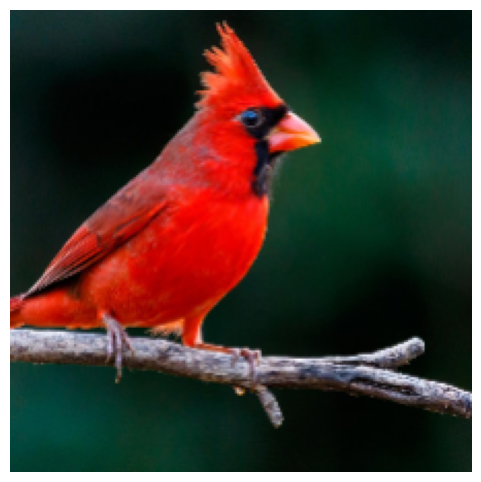

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np

# Replace 'path_to_your_image.jpg' with the path to the image you want to use
img = Image.open("birdtraining9.jpeg")

# Resize the image to match the input shape of the model, e.g., 224x224 for your model
input_shape = (224, 224)  # This should match the input shape your model expects
image = img.resize(input_shape)

# Convert the image to a numpy array and normalize it
image_array = np.array(image) / 255.0  # Assuming your model expects pixel values in [0, 1]

# If your model expects grayscale images and your image is in color (or vice versa), you may need to convert it
# For example, to convert a color image to grayscale: image = image.convert('L') (and adjust input_shape accordingly)

# Expand dimensions to include the batch size
image_array = np.expand_dims(image_array, axis=0)  # Shape becomes (1, 224, 224, 3) for a color image

# Assuming `model_with_stn` is your model
predictions = model_with_stn.predict(image_array)

# Process the predictions as needed (e.g., extract the predicted class)
# This step depends on what your model is predicting (e.g., class probabilities for classification tasks)
predicted_class = np.argmax(predictions, axis=1)

# Assuming `transformed_image_tensor` is your image tensor
# Convert the tensor to a NumPy array
# Make sure to clip values to be in the range [0, 1] if they aren't already
transformed_image_array = np.clip(transformed_image_tensor.numpy(), 0, 1)

# Check if the image has a batch dimension and remove it if present
if len(transformed_image_array.shape) == 4:
    transformed_image_array = transformed_image_array[0]

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(transformed_image_array)
plt.axis('off')  # Hide the axis
plt.show()

In [88]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

def mse_loss(output_image, target_image):
    # Ensure target_image is broadcasted to match the batch size of output_image if necessary
    target_image_broad = tf.broadcast_to(target_image, tf.shape(output_image))
    return tf.reduce_mean(tf.square(output_image - target_image_broad))

@tf.function
def train_step(model, input_image, target_image):
    with tf.GradientTape() as tape:
        # Forward pass: Transform input and get the output from the CNN
        output_image = model(input_image, training=True)
        # Calculate loss between the output and the target image
        loss = mse_loss(output_image, target_image)  # or perceptual_loss

    # Calculate gradients and update model weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Example of a training epoch
def train(model, dataset, target_image, epochs=1):
    for epoch in range(epochs):
        for input_image, _ in dataset:  # Unpack dataset items into images and ignore labels
            loss = train_step(model, input_image, target_image)
            print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")

model = create_cnn_with_stn(input_shape=[224, 224, 3])

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/willkimball/Downloads/archive',
    batch_size=32,  # Adjust based on your system's capability
    image_size=(224, 224)  # Assuming this is the expected input size for your model
)

train(model, dataset, target_image, epochs=10)

Found 89885 files belonging to 3 classes.


ValueError: in user code:

    File "/var/folders/7t/9707gsnn2ybg7l0trr__6kvc0000gn/T/ipykernel_4328/172437581.py", line 14, in train_step  *
        loss = mse_loss(output_image, target_image)  # or perceptual_loss
    File "/var/folders/7t/9707gsnn2ybg7l0trr__6kvc0000gn/T/ipykernel_4328/172437581.py", line 5, in mse_loss  *
        target_image_broad = tf.broadcast_to(target_image, tf.shape(output_image))

    ValueError: Shape must be at most rank 2 but is rank 4 for '{{node BroadcastTo}} = BroadcastTo[T=DT_FLOAT, Tidx=DT_INT32](target_image, Shape)' with input shapes: [1,224,224,3], [2].


In [ ]:
# Output is a 32,10 needs to match the target image which is 224,224